# **Métodos de Monte Carlo**

En esta práctica trabajaremos con el entorno `Blackjack-v1` de **Gymnasium**. Aprenderemos a definir políticas $ɛ$-greedy y a implementar el algoritmo de Monte Carlo off-policy con Weighted Importance Sampling.

Importaremos las librerías necesarias a lo largo de la práctica.

In [2]:
from __future__ import annotations
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
import gymnasium as gym

## Descripción del entorno

La implementación de **Gymnasium** del entorno `Blackjack-v1` es teórica con fines didácticos y no se ajusta por completo al juego real de Blackjack.

El blackjack es un juego de cartas en el que el objetivo es vencer al repartidor (dealer) obteniendo cartas que sumen más cerca de 21 (sin pasarse) que las cartas del repartidor.

El juego comienza con el repartidor teniendo una carta boca arriba y una boca abajo, mientras que el jugador tiene dos cartas boca arriba. Todas las cartas se sacan de un mazo infinito (es decir, con reposición).Los valores de las cartas son:
- Las cartas de figura (J, Q, K) tienen un valor de 10 puntos.
- Si se da la condición de "as usable", los ases pueden contar como 11 o 1.
- Las cartas numéricas (2-10) tienen un valor igual a su número.

El jugador puede solicitar cartas adicionales (acción **HIT**) hasta que decida detenerse (acción **STICK**) o exceda 21 (sobrepasa y es pérdida inmediata). Después de que el jugador se planta, el repartidor revela su carta oculta y toma cartas hasta que su suma sea 17 o mayor. Si el repartidor supera, el jugador gana. Si ni el jugador ni el repartidor superan, el resultado (ganar, perder, empate) se decide por quién tiene una suma más cercana a 21.

### Creación del entorno

Crearemos el entorno `Blackjack-v1`. Añadimos el argumento `sab=True`, nos servirá para seguir las normas que se han establecido anteriormente.

In [3]:
env = gym.make("Blackjack-v1", sab=True)

### Observation space & Action space

El espacio de observaciones se compone de tuplas de 3 componentes tipo `s = (player_sum, dealer_card, usable_ace)` que contienen:
- `player_sum`: La suma actual del jugador
- `dealer_card`: El valor de la carta del repartidor que está boca arriba
- `usable_ace`: Si el jugador tiene "as usable" o no

Como ya sabemos el espacio de acciones tiene 2 posibles acciones:
- `0 = STICK:` plantarse
- `1 = HIT`: pedir carta

In [4]:
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Tuple(Discrete(32), Discrete(11), Discrete(2))
Action space:  Discrete(2)


## Monte Carlo Off-policy Weighted Importance Sampling

Inicializaremos la función de valor de acción $Q(s,a)$ para cada par estado-acción $(s,a)$ con un valor arbitrario, en este caso a cero.

In [5]:
Q = defaultdict(lambda: np.zeros(env.action_space.n))

$C(s, a)$ representa la suma de los pesos de importancia de las ocurrencias del par $(s,a)$ hasta el momento.

Inicializaremos esta suma de pesos acumulados $C(s,a)$ para cada par estado-acción a cero.

In [6]:
C = defaultdict(lambda: np.zeros(env.action_space.n))

Ejercicio 1: Define la política objetivo.

> La política objetivo (*target policy*) $π$ es greedy con respecto a $Q$.  Siempre elige la acción con el mayor valor estimado de $Q$ en ese estado, es decir:
$\pi(s) = argmax_{a} Q(s, a)$.

In [7]:
def target_policy(Q, state):
    # Devuelve la acción greedy
    return np.argmax(Q[state])

Ejercicio 2: Define la política de comportamiento.

> La política de comportamiento (*behavior policy*) $b$ es una política $𝛆$-greedy que explora (devuelve una acción aleatoria) con probabilidad $𝛆$ y explota (devuelve la acción greedy con respecto a $Q$) con probabilidad $1−𝛆$.

In [8]:
def behavior_policy(env, epsilon, Q, state):
    if np.random.rand() < epsilon:
        # Devuelve acción aleatoria
        return env.action_space.sample()
    else:
       return int(np.argmax(Q[state]))
        # Devuelve la acción greedy

Ejercicio 3: Define una función para obtener la probabilidad de escoger cada acción en la política de comportamiento.

> La probabilidad de escoger la acción greedy será $1 - 𝛆 + 𝛆/n_{acciones}$, ya que también puede ser escogida aleatoriamente. La probabilidad de escoger cualquier otra acción será simplemente $𝛆/n_{acciones}$.

In [9]:
def get_behavior_prob(env, epsilon, Q, state, action):
    # Obtén la acción greedy según la política objetivo
    action1=target_policy(Q,state)
    # Si la acción escogida es la acción greedy la probabilidad es 1 - epsilon + epsilon/n_acciones
    if action == action1:
      return (1-epsilon+(epsilon/env.action_space.n))
    else:
    # En otro caso la probabilidad es epsilon/n_acciones
      return epsilon/env.action_space.n

Ejercicio 4: Define una función para implementar un decaimiento lineal de 𝛆.

> Una práctica habitual es usar una decadencia gradual de `epsilon`, permite explorar mucho al inicio y explotar lo aprendido más adelante. Así $ε$ deja de ser un hiperparámetro constante y se actualiza tal que: $ε_{t+1}​=max(ε_{final}​,ε_{t}​−ε_{decay})$

In [10]:
def decay_epsilon(final_epsilon, epsilon_decay, epsilon):
  return max(final_epsilon,epsilon-epsilon_decay)

Ejercicio 5: Define una función para generar episodios siguiendo la política de comportamiento, guardando la trayectoria de recompensas para poder calcular después el retorno del episodio (Práctica 2).

In [11]:
def generate_episode(env, epsilon, Q):
  # Resetear el entorno para obtener el estado inicial
    state, _ = env.reset()
    trajectory =[]
    done=False

    while not done:
      action=behavior_policy(env,epsilon,Q,state)
      next_state, reward, terminated, truncated, _ = env.step(action)
      # El episodio habrá terminado si así lo indican terminated o truncated
      done = terminated or truncated
      # Actualizamos la variable estado al nuevo
      trajectory.append((state,action,reward))
      state = next_state
    return trajectory

Ejercicio 6: Define la función que implementa el algoritmo de Monte Carlo off-policy WIS.

> $W$ acumula el ratio de probabilidades de la política objetivo $π$ sobre la política de comportamiento $b$. Permite corregir el sesgo introducido al muestrear con $b$ pero querer aprender sobre $π$. Al inicio de la cadena de eventos (el final del episodio) $W = 1$, ya que no hay diferencia acumulada en las probabilidades.



> $G$ representa el retorno acumulado. Se inicializa en 0 y se actualiza recorriendo la trayectoria de forma inversa como: $G \;\leftarrow\; \gamma \, G + R_{t+1}$


> El peso de importancia actual $W$ se suma al contador de pesos acumulado para el par estado-acción: $C(s,a)←C(s,a)+W$


> La estimación del valor $Q$ para el par estado-acción $(s, a)$ se actualiza utilizando la ecuación del algoritmo:
$Q(s, a) = Q(s, a) + (W/C(s, a)) * [G - Q(s, a)]$.

> El peso de importancia $W$ se actualiza según $W = W * (π(a|s) / b(a|s))$



> Un aspecto importante en este algoritmo es el truncamiento del procesamiento del episodio si $a \neq π(s)$, es decir, si la acción $a$ tomada en el episodio no es la misma acción que la política objetivo $π$ elegiría en el estado $s$. En ese supuesto $W$ podría volverse muy grande, aumentando la varianza de las estimaciones. Al truncar la trayectoria cuando $a \neq π(s)$, garantizamos que $W$ se mantenga relativamente pequeño. Esto reduce la varianza y mejora la estabilidad del algoritmo.

In [12]:
def mc_wis_update(trajectory, gamma, epsilon, Q, C):
    G = 0.0
    W = 1.0
    trajectory=generate_episode(env, epsilon, Q)
    # Recorre la trayectoria del episodio en sentido inverso
    for state,action,reward in reversed(trajectory):

        # Actualiza el retorno G
        G= gamma*G + reward
        # Actualiza la suma de pesos acumulados C
        C[state][action]= C[state][action]+W
        # Actualiza Q
        Q[state][action]=Q[state][action] +(W/C[state][action])*(G-Q[state][action])
        # Truncamiento
        if action != target_policy(Q, state):
            break

        # Obtén la probabilidad de la acción según target policy
        prob= 1
        # Obtén la probabilidad de la acción según behavior policy
        prob_be= get_behavior_prob(env,epsilon,Q,state,action)
        # Actualiza W
        W= W*(prob/prob_be)

### Entrenamiento del agente

Definimos los hiperparámetros:

In [13]:
n_episodes = 500_000
epsilon = 1
epsilon_decay = 0.0001
final_epsilon = 0.1
gamma = 1.0

Y entrenamos durante el número de episodios definido:

In [14]:
for _ in tqdm(range(n_episodes)):
    # Genera el episodio y obtén la trayectoria
    trajectory=generate_episode(env,epsilon,Q)
    # Aplica el algoritmo de Monte Carlo WIS
    mc_wis_update(trajectory, gamma, epsilon, Q, C)
    # Actualiza el valor de epsilon según el decaimiento lineal
    epsilon=decay_epsilon(final_epsilon,epsilon_decay,epsilon)

100%|██████████| 500000/500000 [01:48<00:00, 4616.31it/s]


## Evaluación del agente

Las funciones `create_grids` y `create_plots` nos ayudarán a visualizar la política aprendida por el agente y los valores de estado en función de la suma del jugador y el valor de la carta que muestra el *dealer*.

En el entorno clásico de Gymnasium, la expectativa a largo plazo de un jugador óptimo es ligeramente negativa (es decir, pierde un poco en promedio), porque el entorno modela el juego “limpio” donde no hay conteo de cartas ni ventajas adicionales.

En el blackjack real de casino, el jugador también juega en desventaja matemática frente a la banca (el dealer gana en promedio). Solo con conteo de cartas o reglas más favorables al jugador se puede acercar a ventaja positiva.

En el entorno de Gymnasium, como no se puede contar cartas (baraja “infinita”), el agente nunca podrá ganar siempre ni tener una ventaja positiva constante.

In [15]:
def create_grids(Q, usable_ace=False):
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in Q.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        np.arange(12, 22),
        np.arange(1, 11),
    )

    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"Valores de estado: {title}")
    ax1.set_xlabel("Suma del jugador")
    ax1.set_ylabel("Carta del dealer")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Política: {title}")
    ax2.set_xlabel("Suma del jugador")
    ax2.set_ylabel("Carta del dealer")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig

Separaremos los resultados según si el jugador tiene "as usable" o no.

**Con as usable**

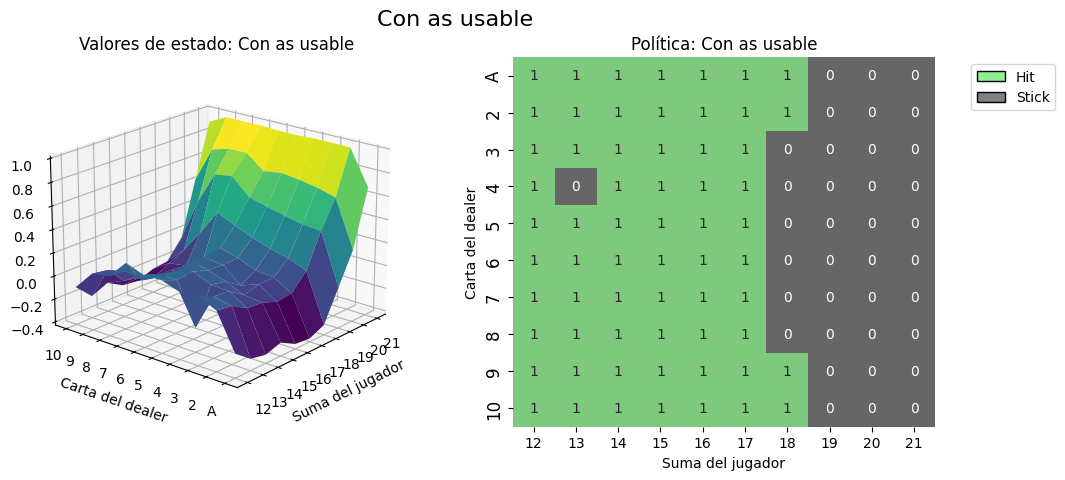

In [16]:
value_grid, policy_grid = create_grids(Q, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="Con as usable")
plt.show()

**Sin as usable**

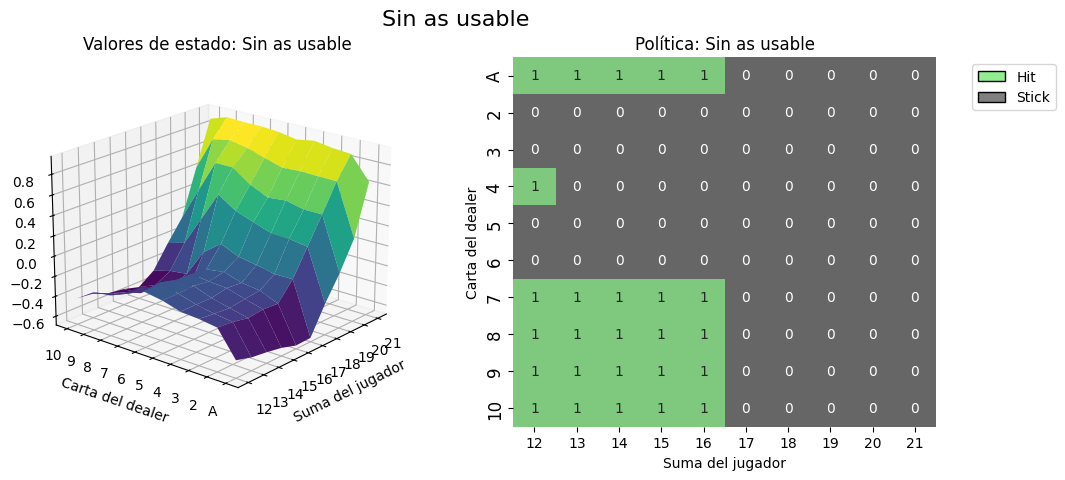

In [17]:
value_grid, policy_grid = create_grids(Q, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Sin as usable")
plt.show()

Cerramos el entorno una vez hemos terminado.

In [18]:
env.close()